# 1. Data processing

### 1.1<u>Get Data</u>

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


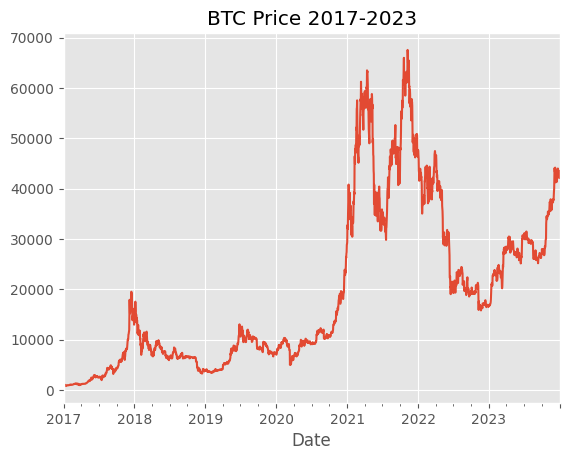

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

# Get stock data
df = yf.download("BTC-USD", start="2017-1-1", end="2024-1-1", interval="1d")
plt.style.use('ggplot')
df['Close'].plot(label='Close', title='BTC Price 2017-2023')

df.head(5)

### 1.2 <u>Process Data</u>

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_dataset(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])

    return np.array(X), np.array(y)

# Get list of closing prices
data = list(df.iloc[:, 3])

# Reshape price data to be 2D -> required by MinMaxScaler
data = np.array(data).reshape(-1, 1)

# Normalize price data
# normalizer = MinMaxScaler()
# data_normalized = normalizer.fit_transform(data)

# Flatten the normalized data back to 1D
# data_normalized = data_normalized.flatten()

seq_length = 30

# X, y = create_dataset(data_normalized, seq_length)
X, y = create_dataset(data, seq_length)

### 1.3 <u>Create training and test set</u>

In [3]:
import random
import torch

test_indexes  = random.sample(range(len(X)), 300)
train_indexes = [i for i in range(len(X)) if i not in test_indexes]

X_test = torch.tensor(X[test_indexes], dtype=torch.float32)
y_test = torch.tensor(y[test_indexes], dtype=torch.float32)

X_train = torch.tensor(X[train_indexes], dtype=torch.float32)
y_train = torch.tensor(y[train_indexes], dtype=torch.float32)

# Set device to CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reshape X,y into (nr_of_samples, seq_length, nr_of_features) -> necessary for LSTM
X_test = torch.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))   # .to(device)
y_test = torch.reshape(y_test, (y_test.shape[0], 1, 1)) #.to(device)

X_train = torch.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))   #.to(device)
y_train = torch.reshape(y_train, (y_train.shape[0], 1, 1))  #.to(device)

# X_train_flat = X_train.reshape(-1,1)
# X_test_flat = X_test.reshape(-1,1)
# y_train_flat = y_train.reshape(-1,1)
# y_test_flat = y_test.reshape(-1,1)


In [14]:
x_temp = X_train
x_temp = x_temp.reshape(-1,1)
x_temp.shape

torch.Size([66780, 1])

# 2. LSTM

In [4]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, fc_features):
        super(LSTM, self).__init__()

        self.num_classes    = num_classes
        self.input_size     = input_size
        self.hidden_size    = hidden_size
        self.num_layers     = num_layers
        self.seq_length     = seq_length

        self.lstm = nn.LSTM(input_size = self.input_size, 
                            hidden_size = self.hidden_size, 
                            num_layers = self.num_layers, 
                            batch_first = True) 
        
        self.fc1 = nn.Linear(self.hidden_size, fc_features)
        self.fc2 = nn.Linear(fc_features, self.num_classes)

        self.relu = nn.ReLU()

    def forward(self, X):
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)

        output, (hn, cn) = self.lstm(X, (h0, c0))

        hn = hn.view(-1, self.hidden_size)

        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out

# 3. Training

In [5]:
# from sklearn.model_selection import KFold
# from torch.amp import GradScaler

# # HYPERPARAMETERS
# NUM_EPOCHS      = 1000
# LEARNING_RATE   = 0.001
# HIDDEN_SIZE     = 32

# # Enable cuDNN autotuner for GPU accelerations
# torch.backends.cudnn.benchmark = True

# # Parameters
# input_size  = 1      # Number of input features
# num_classes = 1     # Number of output classes -> 1, because it needs to output 1 value

# # Hyperparameters
# num_epochs      = 1000
# learning_rate   = 0.001

# hidden_size     = 32        # Number of features in hidden state
# fc_features     = 128       # Size of output of first fully connected layer
# num_layers      = 2         # Number of stacked lstm layers

# batch_size = 3

# # Set loss function to MSE loss
# criterion = nn.MSELoss()

# nr_folds = 10
# kf = KFold(n_splits = nr_folds)

# total_mse = 0

# # Initialize gradscaler (AMP) -> gpu accelerations
# scaler = GradScaler()

In [6]:
# from torch.utils.data import Subset, DataLoader, TensorDataset
# from torch.amp import autocast

# for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
#     print('-------------------')
#     print(f'FOLD {fold}')

#     X_train_fold, y_train_fold = X_train[train_index], y_train[train_index]
#     X_test_fold, y_test_fold   = X_train[test_index], y_train[test_index]

#     train_dataset = TensorDataset(X_train[train_index], y_train[train_index])
#     test_dataset  = TensorDataset(X_train[test_index], y_train[test_index])
    
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
#     test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

#     # Create LSTM object and move it to the GPU
#     lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train.shape[1], fc_features).to(device)

#     # Initialize optimizer
#     optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#     mse_fold = 0

#     # Run training loop for defined number of epochs
#     for epoch in range(0, num_epochs):
#         print(f'epoch {epoch}')

#         # Set current loss
#         current_loss = 0.0

#         # Iterate over dataloader for training
#         for i, data in enumerate(train_loader, 0):
#             # Get inputs and labels
#             inputs, targets = data
#             inputs  = inputs.to(device)
#             targets = targets.to(device)

#             print(inputs.shape)

#             # Zero the gradients
#             optimizer.zero_grad()

#             with autocast(device_type="cuda"):
#                 # Perform forward pass
#                 outputs = lstm.forward(inputs)

#                 # Compute loss
#                 loss = criterion(outputs, targets)
#                 print(loss)
            

In [18]:
from torch.utils.data import Subset, DataLoader, TensorDataset
from torch.amp import autocast

for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    print('-------------------')
    print(f'FOLD {fold}')

    # Extract training and test data
    X_train_fold, y_train_fold = X_train[train_index], y_train[train_index]
    X_test_fold, y_test_fold = X_train[test_index], y_train[test_index]

    # Initialize scalers
    feature_scaler = MinMaxScaler()
    label_scaler = MinMaxScaler()

    # Reshape training data to 2D for normalization
    X_train_reshaped = X_train_fold.reshape(-1, X_train_fold.shape[-1])  # shape: (nr_train_sequences * sequence_length, nr_of_features)
    y_train_reshaped = y_train_fold.reshape(-1, y_train_fold.shape[-1])  # shape: (nr_train_sequences * sequence_length, nr_of_features)

    # Fit the scaler on the training data
    X_train_normalized = feature_scaler.fit_transform(X_train_reshaped)
    y_train_normalized = label_scaler.fit_transform(y_train_reshaped)

    # Reshape back to 3D
    X_train_normalized = X_train_normalized.reshape(X_train_fold.shape)
    y_train_normalized = y_train_normalized.reshape(y_train_fold.shape)

    # Normalize the test data using the fitted scaler from the training data
    X_test_reshaped = X_test_fold.reshape(-1, X_test_fold.shape[-1])
    y_test_reshaped = y_test_fold.reshape(-1, y_test_fold.shape[-1])

    X_test_normalized = feature_scaler.transform(X_test_reshaped)
    y_test_normalized = label_scaler.transform(y_test_reshaped)

    # Reshape back to 3D
    X_test_normalized = X_test_normalized.reshape(X_test_fold.shape)
    y_test_normalized = y_test_normalized.reshape(y_test_fold.shape)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_normalized, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_normalized, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    # Create LSTM object and move it to the GPU
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train.shape[1], fc_features).to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    mse_fold = 0

    # Run training loop for defined number of epochs
    for epoch in range(0, num_epochs):
        print(f'epoch {epoch}')

        # Set current loss
        current_loss = 0.0

        # Iterate over dataloader for training
        for i, data in enumerate(train_loader, 0):
            # Get inputs and labels
            inputs, targets = data
            inputs  = inputs.to(device)
            targets = targets.to(device)

            print(inputs.shape)

            # Zero the gradients
            optimizer.zero_grad()

            with autocast(device_type="cuda"):
                # Perform forward pass
                outputs = lstm.forward(inputs)

                # Compute loss
                loss = criterion(outputs, targets)
                print(loss)
            

-------------------
FOLD 0
epoch 0
torch.Size([3, 30, 1])


/home/rdr/Documents/Trading_bot/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1060, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.0556, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.1274, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.3972, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.4319, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.1044, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.2656, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.3198, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.1827, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.1226, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.3550, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.0377, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tens

/home/rdr/Documents/Trading_bot/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.3688, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.0640, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.3489, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.4304, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.5051, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.1874, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.3763, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.1751, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.1484, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.3723, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.1881, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tensor(0.1120, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([3, 30, 1])
tens

KeyboardInterrupt: 